
# PNP Finite Difference

The equations:



$$\frac{\partial C_p}{\partial t} = \nabla^2 C_p + \nabla(C_p\nabla \phi)$$

$$\frac{\partial C_n}{\partial t} = \nabla^2 C_n - \nabla(C_n\nabla \phi)$$

$$\nabla^2 \phi = C_n - C_p$$


And the boundary conditions:
$$\nabla C_p (x=L_x) = \nabla C_p (x=0) = \nabla C_n (x=L_x) = \nabla C_n (x=0)=0$$

$$\phi(L_x) = 1, \phi(0) = -1$$

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Simulation Constants
dx = 0.01
L = 1
M = int(L/dx)

dt = 1e-5
T = 5
N = int(T / dt)

phi_neumann = False
n_neumann = True
phi_neumann = True


## Finite Difference

### Finding $\phi$

I will use the implicit finite difference method.
After applying finite difference, the potential $\phi(x,t)$ at the point $x_m, 0<m<M-1$ would be:

$$\frac{\Delta x^2}{2}(p_m - n_m) = \phi_m -\frac{1}{2} \phi_{m+1} -\frac{1}{2} \phi_{m-1} $$

#### Dirichlet
So solving for $\phi$ at a certain time would mean solving the following matrix:

$$
\begin{gather}
   \begin{bmatrix}
      1 & -\frac{1}{2} & 0 & 0 & ... \\
      -\frac{1}{2} & 1 & -\frac{1}{2} & 0 & ... \\
      ... & ... \\
      ... & 0 & -\frac{1}{2} & 1 & -\frac{1}{2} \\
      ... & 0 & 0 & -\frac{1}{2} & 1
   \end{bmatrix}
   \begin{bmatrix}
      \phi_1 \\
      \phi_2 \\
      ... \\
      \phi_{M-3} \\
      \phi_{M-2}
   \end{bmatrix}
 
 =
 \frac{\Delta x^2}{2}
  \begin{bmatrix}
   p_1 - n_1 + \frac{1}{\Delta x^2} \phi_0 \\
   p_2 - n_2 \\
   ... \\
   p_{M-3} - n_{M-3} \\
   p_{M-2} - n_{M-2} + \frac{1}{\Delta x^2} \phi_M

   \end{bmatrix}
\end{gather} $$

Notice that A is composed of $(M-2)$ ones, and $(M-3)$ elements $-\frac{1}{2}$ on each diagonal.  

#### Neumann
With Neumann boundary conditions we get for the edges:

$$ \phi_1 - \phi_0 = \Delta x n_l $$
$$ \phi_{M-1} - \phi_{M-2} =\Delta x n_r $$

Where $n_l, n_r$ are the fluxes at the edges. So we end up with:

$$
\begin{gather}
   \begin{bmatrix}
      -1 & 1 & 0 & 0 & ... \\
      -\frac{1}{2} & 1 & -\frac{1}{2} & 0 & ... \\
      ... & ... \\
      ... & 0 & -\frac{1}{2} & 1 & -\frac{1}{2} \\
      ... & 0 & 0 & -1 & 1
   \end{bmatrix}
   \begin{bmatrix}
      \phi_0 \\
      \phi_1 \\
      ... \\
      \phi_{M-2} \\
      \phi_{M-1}
   \end{bmatrix}
 
 =
 \frac{\Delta x^2}{2}
  \begin{bmatrix}
   \Delta x n_l \\
   p_1 - n_1 \\
   ... \\
   p_{M-2} - n_{M-2} \\
   \Delta x n_r

   \end{bmatrix}
\end{gather} $$


In [10]:
def get_phi(phi_0, phi_M, n, p, dx, n_l=0, n_r=0):
    # TODO: add phi_neumann conditions

    # Creating the coeff matrix
    coeff_matrix = np.diag(np.ones(M-2)) + np.diag(-0.5*np.ones(M-3), 1) + np.diag(-0.5*np.ones(M-3), -1)

    # Creating the RHS result vector
    result_vector = np.array([p[m]-n[m] for m in range(2, M-2)])
    right_res = p[M-2] - n[M-2] + phi_M/(dx**2)
    left_res = p[1] - n[1] + phi_0/(dx**2)
    result_vector = ((dx**2)/2)*np.append(np.insert(result_vector, 0, left_res), right_res)

    # Solving for phi and adding the boundry
    phi_trimmed = np.linalg.solve(coeff_matrix, result_vector)
    phi = np.append(np.insert(phi_trimmed, 0, phi_0), phi_M)

    return phi

# Test
get_phi(-1, 1, np.random.rand(M), np.random.rand(M), dx)


array([-1.00000000e+00, -9.80197231e-01, -9.60356045e-01, -9.40510405e-01,
       -9.20706740e-01, -9.00874149e-01, -8.81045138e-01, -8.61225623e-01,
       -8.41375194e-01, -8.21587118e-01, -8.01750326e-01, -7.81849429e-01,
       -7.61970030e-01, -7.42073735e-01, -7.22214310e-01, -7.02366654e-01,
       -6.82502206e-01, -6.62642560e-01, -6.42766634e-01, -6.22929780e-01,
       -6.03145141e-01, -5.83292108e-01, -5.63366180e-01, -5.43450332e-01,
       -5.23534961e-01, -5.03586148e-01, -4.83597689e-01, -4.63559335e-01,
       -4.43510614e-01, -4.23534598e-01, -4.03486955e-01, -3.83382725e-01,
       -3.63208441e-01, -3.43030863e-01, -3.22886488e-01, -3.02702943e-01,
       -2.82521321e-01, -2.62303565e-01, -2.42084450e-01, -2.21854886e-01,
       -2.01650011e-01, -1.81449263e-01, -1.61266660e-01, -1.41080764e-01,
       -1.20887025e-01, -1.00653352e-01, -8.03577397e-02, -6.00998228e-02,
       -3.98621400e-02, -1.96202422e-02,  6.08652263e-04,  2.08992721e-02,
        4.12503687e-02,  

## Iterating $p, n$

Iterating $p(x,t), n(x,t)$ means finding $p_m^{i+1}, n_m^{i+1}$. We assume that we have $p_m^j, n_m^j$ for every $m, j<i$.
I will use explicit central difference method to get:

$$ 
\begin{align}
p_m^{i+1} = p_m^{i} + \frac{\Delta t}{\Delta x^2} \left( p_{m+1}^i + p_{m-1}^i - 2p_m^i + \frac{1}{4}(p_{m+1}^i-p_{m-1}^i)(\phi_{m+1}^i-\phi_{m-1}^i) + p_m^i(\phi_{m+1}^i+\phi_{m-1}^i-2\phi_m^i) \right)
\end {align}
$$

$$ 
\begin{align}
n_m^{i+1} = n_m^{i} + \frac{ \Delta t}{\Delta x^2} \left( n_{m+1}^i + n_{m-1}^i - 2n_m^i - \frac{1}{4}(n_{m+1}^i-n_{m-1}^i)(\phi_{m+1}^i-\phi_{m-1}^i) - n_m^i(\phi_{m+1}^i+\phi_{m-1}^i-2\phi_m^i) \right)
\end {align}
$$


In [11]:
def iterate_concentration(c, phi, dx, dt, positive, flux_l=0, flux_r=0, neumann=False):
    """
    Assume c and phi are 1XM vectors 
    c_pp - c-prime-prime, cp - c-prime, phi_pp - phi-prime-prime, phi_p - phi-prime
    
    """
    sign = 1 if positive else -1

    c_1, c_M = c[0], c[M-1]
    phi_1, phi_M = phi[0], phi[M-1]
    # c_prev_1, c_prev_M = c_prev[0], c_prev[M-1]


    c_rolled = np.roll(c, 1)
    c_rolled_back = np.roll(c, -1)
    np.put(c_rolled, [0, -1], [c_1, c_M]) # Creating c_{m+1}
    np.put(c_rolled_back, [0, -1], [c_1, c_M]) # Creating c_{m-1}

    phi_rolled = np.roll(phi, 1)
    phi_rolled_back = np.roll(phi, -1)
    np.put(phi_rolled, [0, -1], [phi_1, phi_M]) # Creating phi_{m+1}
    np.put(phi_rolled_back, [0, -1], [phi_1, phi_M]) # Creating phi_{m+1}

    c_pp = c_rolled + c_rolled_back - 2*c
    c_p = c_rolled - c_rolled_back
    
    phi_pp = phi_rolled + phi_rolled_back - 2*phi
    phi_p = phi_rolled - phi_rolled_back
    # print(phi_p, phi_pp)

    c_iter = c + dt/(dx**2)*(c_pp + (1/4)*sign*c_p*phi_p + sign*c*phi_pp)
    
    if neumann:
        c_iter[0] = c_iter[1]-dx*flux_l
        c_iter[-1] = c_iter[-2]+dx*flux_r

    # print(c-c_iter)

    return c_iter

# Test
# iterate_concentration(np.random.rand(M), np.random.rand(M), np.random.rand(M), 0.1, 0.001, True)


## Simulation
We iterate according to the following algorithm:

Assume we know $ \phi_m^{i-1} n_m^{i-1}, p_m^{i-1}$ for every $m = 1,2,...M$ (and the boundry conditions)

Then iterate to the next step according to:

1. Finding $n_m^{i}, p_m^{i}$ for every $m$ based on $\phi_m^{i-1}, n_m^{i-1}, p_m^{i-1}$
2. Finding $\phi_m^{i}$ based on $n_m^{i}, p_m^{i}$ for every $m$, using implicit finite difference. 

In [12]:
def iterate(phi, n, p, dx, dt, neumann):
    phi_0 = phi[0]
    phi_M = phi[M-1]

    next_n = iterate_concentration(n, phi, dx, dt, positive=False, neumann=neumann)
    next_p = iterate_concentration(p, phi, dx, dt, positive=True, neumann=neumann)
    next_phi = get_phi(phi_0, phi_M, next_n, next_p, dx)

    return next_phi, next_n, next_p

In [20]:

# Physics Constants
D = 1 
epsilon = 1

x = np.linspace(0, L, M)
t = np.linspace(0, N, T)
n, p, phi = np.zeros((N, M)), np.zeros((N, M)), np.zeros((N, M))

# Initial Conditions

# n[0, :] = 4*(1+0.8*np.random.rand(M))
# p[0, :] = 4*(1+0.8*np.random.rand(M))
n[0, :] = np.exp(-(x-L/2)**2)
p[0, :] = np.exp(-(x-L/2)**2)
# phi[0, :] = 1/(1+np.exp(-(x-L/2)))
phi[0, :] = 10*((2/L)*x-1)


# Dirichlet Boundry
phi[:, 0] = 0
phi[:, M-1] = 0

# Neumann Boundry
# n[:, 0] = 0
# n[:, M-1] = 0

# p[:, 0] = 0
# p[:, M-1] = 0

KeyboardInterrupt: 

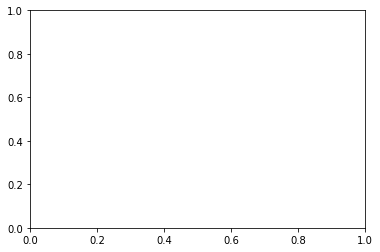

In [21]:
fig = plt.figure()
axis = plt.axes(xlim = (0, L), ylim = (0.45, 0.55))


for i in range(1, N):
    # print(phi[i,:])

    phi_i, n_i, p_i = iterate(phi[i-1, :], n[i-1, :], p[i-1, :], dx, dt, neumann=True)
    

    n[i, :] = n_i
    p[i, :] = p_i
    phi[i, :] = phi_i
    # print(phi[i,:])
    if i == N-1:
        phi[i, :] = get_phi(phi[i, 0], phi[i, M-1], p[i, :], n[i, :], dx)

    if i % 20 == 0:
            
        # axis.set_ylim(3.5, 6.5)
        axis.plot(x, p[i-1,:], label="$C_p$" )
        axis.plot(x, n[i-1,:], label="$C_n$")
        axis.legend() 
        fig.savefig(f"./pnp3/frame_{i}.png")
        axis.clear()

AttributeError: Figure.show works only for figures managed by pyplot, normally created by pyplot.figure()

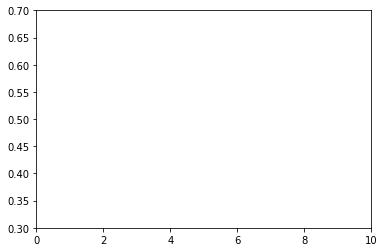

In [ ]:
fig = plt.figure()

axis = plt.axes(xlim = (0, L), ylim = (0.3, 0.7))
# axis.legend()

n_plot, = axis.plot([], [], lw=2, label="$C_n$")
p_plot, = axis.plot([], [], lw=2, label="$C_p$")

def init():
    
    n_plot.set_data(x, n[0,:])
    p_plot.set_data(x, p[0,:])


    return n_plot, 

def animate(i):
    phi_i, n_i, p_i = iterate(phi[i-1, :], n[i-1, :], p[i-1, :], dx, dt, neumann=True)

    n[i, :] = n_i
    p[i, :] = p_i
    phi[i, :] = phi_i

    if i == N-1:
        phi[i, :] = get_phi(phi[i, 0], phi[i, M-1], p[i, :], n[i, :], dx)
    
    n_plot.set_data(x, n[i-1,:])
    p_plot.set_data(x, p[i-1,:])

    return n_plot, 

anim = FuncAnimation(fig, animate, init_func=init, frames=100, interval=10, blit=True)
anim.save("pnp.mp4", fps=30)